## 加载数据集

In [2]:
import numpy as np
from urllib import request
import gzip
import pickle

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], "../datasets/" + name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open("../datasets/" + name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open("../datasets/" + name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("../datasets/" + "mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init_mnist():
    download_mnist()
    save_mnist()
    
init_mnist()

Download complete.
Save complete.


## 划分训练测试集

In [6]:
# 获取MNIST数据集
data_path = r'../datasets/mnist.pkl'
def load_data(data_path):
    with open(data_path, "rb") as f:
        data = pickle.load(f)
    return data
data = load_data(data_path)

In [9]:
X_train, X_test, y_train, y_test = data['training_images'], data['test_images'], data['training_labels'], data['test_labels'], 

In [11]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

## 对数据进行标准化、归一化

In [13]:
X_train = X_train /  255.0
X_test = X_test / 255.0

X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

In [16]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## 标签独热编码

In [17]:
def one_hot_encoding(labels, num_classes):
    one_hot_labels = []
    for label in labels:
        one_hot = [0] * num_classes
        one_hot[label] = 1
        one_hot_labels.append(one_hot)
    return one_hot_labels

num_classes = 10
y_train = one_hot_encoding(y_train , num_classes)
y_test = one_hot_encoding(y_test , num_classes)

y_train = np.array(y_train)
y_test = np.array(y_test)

## 定义网络结构

In [24]:
'''
input_size = X_train.shape[1]
hidden_size_1 = 128
hidden_size_2 = 64
output_size = num_classes
'''
hidden_size = [X_train.shape[1], 128, 64, num_classes]

In [30]:
num_layers = 3
W, b = [], []
W.append(0), b.append(0) # 下标从1开始，更好对应
for i in range(num_layers):
    w = np.random.randn(hidden_size[i], hidden_size[i + 1]) / np.sqrt(hidden_size[i])
    _b = np.zeros(hidden_size[i + 1])
    W.append(w)
    b.append(_b)

In [29]:
class Func:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def softmax(x):
        exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exps / np.sum(exps, axis=-1, keepdims=True)

    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
        n_samples = y_pred.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-12)) / n_samples
        return loss

In [53]:
def train(X, y_true, lr):
    global W, b
    # 前向传播
    Z, A = [], []
    Z.append(0), A.append(X) # 下标从1开始。A[0]其实就是输入X
    for i in range(1, num_layers + 1):
        z = np.dot(A[i - 1], W[i]) + b[i]
        a = Func.relu(z)
        Z.append(z)
        A.append(a)
    batch_size = y_true.shape[0]
    y_pred = Func.softmax(Z[3])
    Loss = Func.cross_entropy_loss(y_pred, y_true)
    
    gred_y_pred = y_pred - y_true  # 对z3(也就是没过softmax函数输出的梯度)
    gred_W, gred_b = [], []
    gred_W.append(0)
    gred_b.append(0)  # 为了下标从1开始
    # W3, b3
    gred_W3 = 1.0 / batch_size * np.dot(A[2].T, gred_y_pred) 
    gred_b3 = 1.0 / batch_size * np.sum(gred_y_pred, axis=0)
    
    # a2, z2, W2, b2
    gred_a2 = np.dot(gred_y_pred, W[3].T)
    gred_z2 = gred_a2.copy()
    gred_z2[Z[2] < 0] = 0
    gred_W2 = 1.0 / batch_size * np.dot(A[1].T, gred_z2) 
    gred_b2 = 1.0 / batch_size * np.sum(gred_z2, axis=0)
    
    # a1, z1, W1, b1
    gred_a1 = np.dot(gred_z2, W[2].T)
    gred_z1 = gred_a1.copy()
    gred_z1[Z[1] < 0] = 0
    gred_W1 = 1.0 / batch_size * np.dot(X.T, gred_z1) 
    gred_b1 = 1.0 / batch_size * np.sum(gred_z1, axis=0)
    # 单纯为了放在一起方便观察
    gred_W.append(gred_W1)
    gred_W.append(gred_W2) 
    gred_W.append(gred_W3) 
    gred_b.append(gred_b1)
    gred_b.append(gred_b2) 
    gred_b.append(gred_b3) 
    for i in range(num_layers):
        W[i] -= lr * gred_W[i]
        b[i] -= lr * gred_b[i]
        
    return Loss

In [39]:
def forward(X):
    global W, b
    z1 = np.dot(X, W[1]) + b[1]
    a1 = Func.relu(z1)
    z2 = np.dot(a1, W[2]) + b[2]
    a2 = Func.relu(z2)
    z3 = np.dot(a2, W[3]) + b[3]
    y_pred = Func.softmax(z3)
    return np.argmax(y_pred, axis=1)

In [64]:
np.random.permutation(5)

array([0, 2, 3, 4, 1])

In [55]:
learning_rate = 0.1
num_epochs = 25
batch_size = 64
num_batches = X_train.shape[0] // batch_size

train_loss_history = []
train_acc_history = []
test_acc_history = []
for epoch in range(num_epochs):
    # 在每个epoch前随机打乱训练数据
    permutation = np.random.permutation(X_train.shape[0])
    X_train = X_train[permutation]
    y_train = y_train[permutation]
    for i in range(num_batches):
        # 从训练数据中随机抽取一个batch
        X_batch = X_train[i * batch_size:(i + 1) * batch_size]
        y_batch = y_train[i * batch_size:(i + 1) * batch_size]

        # 训练一个batch，并记录损失函数值
        loss = train(X_batch, y_batch, learning_rate)
        train_loss_history.append(loss)

    # 计算训练集和测试集上的精度
    train_acc = np.mean(forward(X_train) == np.argmax(y_train, axis=-1))
    test_acc = np.mean(forward(X_test) == np.argmax(y_test, axis=-1))
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)

    # 输出训练进度
    print('Epoch %d/%d, train loss: %f, train acc: %f, test acc: %f' % (epoch+1, num_epochs, loss, train_acc, test_acc))

Epoch 1/25, train loss: 0.227798, train acc: 0.975617, test acc: 0.968100
Epoch 2/25, train loss: 0.050497, train acc: 0.982017, test acc: 0.972200
Epoch 3/25, train loss: 0.160170, train acc: 0.986117, test acc: 0.976500
Epoch 4/25, train loss: 0.041776, train acc: 0.987150, test acc: 0.975300
Epoch 5/25, train loss: 0.005422, train acc: 0.991233, test acc: 0.976900
Epoch 6/25, train loss: 0.012541, train acc: 0.993450, test acc: 0.977700
Epoch 7/25, train loss: 0.011655, train acc: 0.994600, test acc: 0.979100
Epoch 8/25, train loss: 0.024442, train acc: 0.995283, test acc: 0.977500
Epoch 9/25, train loss: 0.009057, train acc: 0.996883, test acc: 0.980300
Epoch 10/25, train loss: 0.009868, train acc: 0.997000, test acc: 0.979100
Epoch 11/25, train loss: 0.003430, train acc: 0.997750, test acc: 0.978800
Epoch 12/25, train loss: 0.019164, train acc: 0.998917, test acc: 0.979000
Epoch 13/25, train loss: 0.011055, train acc: 0.999267, test acc: 0.980100
Epoch 14/25, train loss: 0.010666,

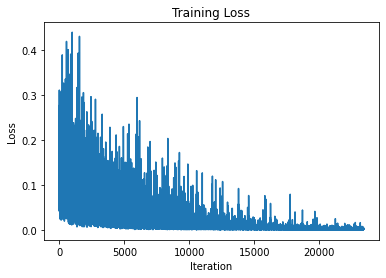

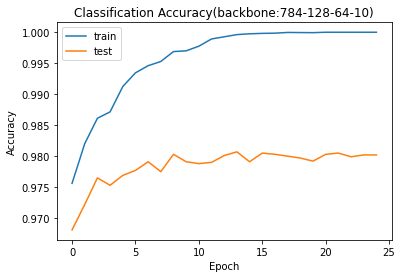

In [56]:
import matplotlib.pyplot as plt
plt.plot(train_loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

plt.plot(train_acc_history, label='train')
plt.plot(test_acc_history, label='test')
plt.title('Classification Accuracy(backbone:784-128-64-10)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('backbone.png')
plt.show()